In [1]:
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm, trange
#import pickle5 as pickle


# import matplotlib
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import cm
import plotly.express as px
from difflib import SequenceMatcher
import seaborn as sns

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go

In [3]:
# "morbilidad_global_ts": is data filtered, under 2018 and the record are only from Lima
#all_data = pd.read_pickle('data/morbilidad_global_lima.pkl')
all_data = pd.read_pickle('data/morbilidad_global_ts.pkl')

In [4]:
# Data grouped by Category (I, II, ...) and Sector (Private & public), for every date
data =  all_data.groupby(['DATE', 'SECTOR','CATEGORY2', 'DIAGNOSIS_ID']).agg({'QTY_PEOPLE_SERVED': "sum"})
data = data.reset_index()
data =  data.groupby(['DATE', 'SECTOR','CATEGORY2']).agg({'QTY_PEOPLE_SERVED': "sum",
                                                          'DIAGNOSIS_ID': "count"})
data = data.reset_index()
data.head()
del all_data

In [5]:
import datetime
import pandas as pd
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import plotly.express as px
 
def retrain_model(df, column_index = 'DATE' , column_values = 'ORIGINAL_VALUES_PRE',kind_model = 'linear'):
    months = [x.month for x in df[column_index]]
    years = [x.year for x in df[column_index]]
    day = [x.day for x in df[column_index]]

    X = np.array([day, months, years]).T
    
    if kind_model == 'linear':
        model = LinearRegression()
    elif kind_model == 'rfg':
        model = RandomForestRegressor()
    elif kind_model == 'xgb':
        model = xgb.XGBRegressor()
    else:
        model = LinearRegression()
        
    model.fit(X, df[column_values].values)
    return model
 
def forecast_model(model, df, column_name = 'DATE', name_predicted = 'PREDICTED'):
    months = [x.month for x in df[column_name]]
    years = [x.year for x in df[column_name]]
    day = [x.day for x in df[column_name]]

    X = np.array([day, months, years]).T

    preds = model.predict(X)
    df[name_predicted] = preds
    return df

def forecast_model_2(df_base, df, column_name = 'DATE', column_values = 'PRE_COVID', name_predicted = 'PREDICTED', kind_model = 'linear'):
    df_resp = pd.DataFrame()
    for i in range(len(df)):
        #df_temp = df.iloc[[2]]
        df_temp = df.iloc[[i]].reset_index(drop=True).copy()
        #i += 1
        model_temp = retrain_model(df_base, column_index = column_name, column_values = column_values, kind_model=kind_model)
        temp_resp = forecast_model(model_temp,
                                   df_temp,
                                   column_name = column_name, 
                                   name_predicted = column_values)
        df_base = pd.concat([df_base,temp_resp])
        df_resp = pd.concat([df_resp,temp_resp])
    df_resp = df_resp.rename({column_values: name_predicted}, axis=1) 
    return df_resp

### Category III

In [6]:
TAG_CATEGORY = 'III'

In [7]:
data_category = data[(data['CATEGORY2']==TAG_CATEGORY)]
data_category = data_category.pivot_table(index=['DATE'],
                                          columns=['SECTOR'],
                                          values='QTY_PEOPLE_SERVED').fillna(0)
data_category = data_category.reset_index().rename_axis(None, axis=1)

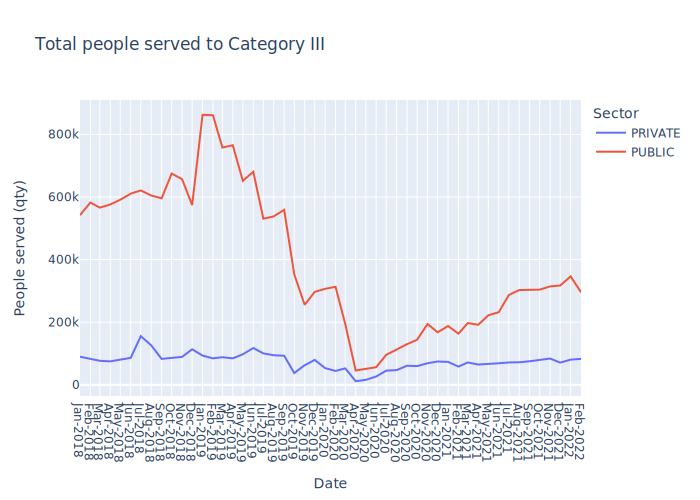

In [8]:
columns_name = list(data_category.columns)[1:]
fig = px.line(data_category, 
              x="DATE", 
              y=columns_name,
              hover_data={"DATE": "|%Y %b"},
              labels={
                     "value": "People served (qty)",
                     "DATE": "Date",
                     "variable": "Sector"
                 },
              title='Total people served to Category ' + TAG_CATEGORY)

fig.update_xaxes(
    dtick="M1",
    tickformat="%b-%Y")

#fig.show()
fig.show(renderer="svg")

### Public

In [9]:
TAG_SECTOR = 'PUBLIC'

data_sector_ts = data_category[['DATE', TAG_SECTOR]]
data_sector_ts = data_sector_ts.rename({TAG_SECTOR: 'ORIGINAL_VALUES'}, axis=1) 


start = data_sector_ts['DATE'].min()
periods = 360*7
daterange = []
for day in range(periods):
    date = (start + datetime.timedelta(days = day)).isoformat()
    daterange.append(date)
    
forecast_df = pd.DataFrame(daterange, columns=['DATE'])
forecast_df['DATE'] = pd.to_datetime(forecast_df['DATE'])
forecast_df = forecast_df[forecast_df['DATE'].dt.strftime('%d') == '01']
forecast_df = forecast_df.reset_index(drop=True)

forecast_df = pd.merge(forecast_df, data_sector_ts, how='left', on=('DATE','DATE'))

In [10]:
# result = seasonal_decompose(data_sector_ts)
# result.plot()

#### Pre covid

In [11]:
# Change for every category and sector, according values on time
data_sector_ts_pre = data_sector_ts[(data_sector_ts['DATE'] < '2019-10')].reset_index(drop=True)
data_sector_ts_pre = data_sector_ts_pre.rename({'ORIGINAL_VALUES': 'PRE_COVID'}, axis=1) 

forecast_df = pd.merge(forecast_df, data_sector_ts_pre, how='left', on=('DATE','DATE'))

umbral = data_sector_ts_pre['DATE'].max().strftime('%Y-%m')

# model_forecast = retrain_model(data_sector_ts_pre, column_index = 'DATE' , column_values = 'PRE_COVID')
# temp_resp = forecast_model(model_forecast, 
#                            forecast_df[(forecast_df['DATE'] >= umbral)][['DATE']],
#                            column_name = 'DATE', 
#                            name_predicted = 'PRE_COVID_FORECAST')

temp_resp = forecast_model_2(data_sector_ts_pre,
                             forecast_df[(forecast_df['DATE'] >= umbral)][['DATE']],
                             column_name = 'DATE',
                             column_values = 'PRE_COVID',
                             name_predicted = 'PRE_COVID_FORECAST',
                             kind_model = 'rfg')

forecast_df = pd.merge(forecast_df, temp_resp, how='left', on=('DATE','DATE'))

#### Post covid

In [12]:
data_sector_ts_post = data_sector_ts[(data_sector_ts['DATE'] > '2020-03')].reset_index(drop=True)
data_sector_ts_post = data_sector_ts_post.rename({'ORIGINAL_VALUES': 'POST_COVID'}, axis=1) 

forecast_df = pd.merge(forecast_df, data_sector_ts_post, how='left', on=('DATE','DATE'))

umbral = data_sector_ts_post['DATE'].max().strftime('%Y-%m')

model_forecast = retrain_model(data_sector_ts_post, column_index = 'DATE' , column_values = 'POST_COVID', kind_model = 'linear')
temp_resp = forecast_model(model_forecast, 
                           forecast_df[(forecast_df['DATE'] >= umbral)][['DATE']],
                           column_name = 'DATE', 
                           name_predicted = 'POST_COVID_FORECAST')

temp_resp = forecast_model_2(data_sector_ts_post,
                             forecast_df[(forecast_df['DATE'] >= umbral)][['DATE']],
                             column_name = 'DATE',
                             column_values = 'POST_COVID',
                             name_predicted = 'POST_COVID_FORECAST',
                             kind_model = 'linear')


forecast_df = pd.merge(forecast_df, temp_resp, how='left', on=('DATE','DATE'))

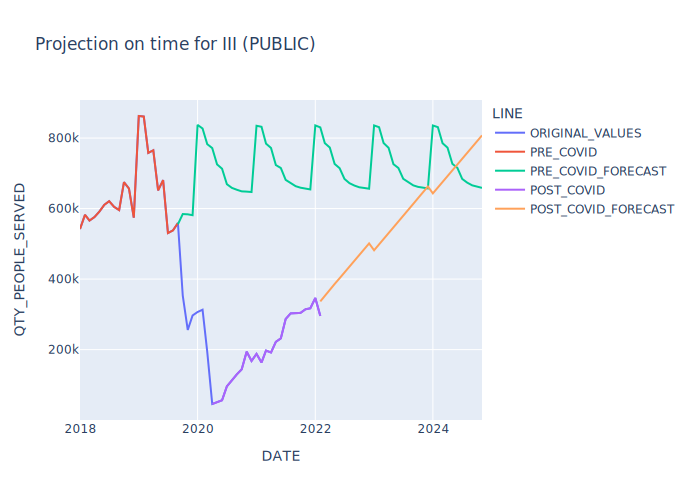

In [13]:
forecast_df = forecast_df.melt(id_vars=['DATE'],
                               var_name="LINE",
                               value_name="QTY_PEOPLE_SERVED")


fig = px.line(forecast_df,
              x="DATE",
              y="QTY_PEOPLE_SERVED",
              color='LINE',
              title='Projection on time for ' + TAG_CATEGORY +' ('+TAG_SECTOR+')')

#fig.show()
fig.show(renderer="svg")

### Private

In [14]:
TAG_SECTOR = 'PRIVATE'

data_sector_ts = data_category[['DATE', TAG_SECTOR]]
data_sector_ts = data_sector_ts.rename({TAG_SECTOR: 'ORIGINAL_VALUES'}, axis=1) 


start = data_sector_ts['DATE'].min()
periods = 360*7
daterange = []
for day in range(periods):
    date = (start + datetime.timedelta(days = day)).isoformat()
    daterange.append(date)
    
forecast_df = pd.DataFrame(daterange, columns=['DATE'])
forecast_df['DATE'] = pd.to_datetime(forecast_df['DATE'])
forecast_df = forecast_df[forecast_df['DATE'].dt.strftime('%d') == '01']
forecast_df = forecast_df.reset_index(drop=True)

forecast_df = pd.merge(forecast_df, data_sector_ts, how='left', on=('DATE','DATE'))

In [15]:
# Change for every category and sector, according values on time
data_sector_ts_pre = data_sector_ts[(data_sector_ts['DATE'] < '2019-10')].reset_index(drop=True)
data_sector_ts_pre = data_sector_ts_pre.rename({'ORIGINAL_VALUES': 'PRE_COVID'}, axis=1) 

forecast_df = pd.merge(forecast_df, data_sector_ts_pre, how='left', on=('DATE','DATE'))

umbral = data_sector_ts_pre['DATE'].max().strftime('%Y-%m')

# model_forecast = retrain_model(data_sector_ts_pre, column_index = 'DATE' , column_values = 'PRE_COVID')
# temp_resp = forecast_model(model_forecast, 
#                            forecast_df[(forecast_df['DATE'] >= umbral)][['DATE']],
#                            column_name = 'DATE', 
#                            name_predicted = 'PRE_COVID_FORECAST')

temp_resp = forecast_model_2(data_sector_ts_pre,
                             forecast_df[(forecast_df['DATE'] >= umbral)][['DATE']],
                             column_name = 'DATE',
                             column_values = 'PRE_COVID',
                             name_predicted = 'PRE_COVID_FORECAST',
                             kind_model = 'rfg')

forecast_df = pd.merge(forecast_df, temp_resp, how='left', on=('DATE','DATE'))

In [16]:
data_sector_ts_post = data_sector_ts[(data_sector_ts['DATE'] > '2020-03')].reset_index(drop=True)
data_sector_ts_post = data_sector_ts_post.rename({'ORIGINAL_VALUES': 'POST_COVID'}, axis=1) 

forecast_df = pd.merge(forecast_df, data_sector_ts_post, how='left', on=('DATE','DATE'))

umbral = data_sector_ts_post['DATE'].max().strftime('%Y-%m')

model_forecast = retrain_model(data_sector_ts_post, column_index = 'DATE' , column_values = 'POST_COVID', kind_model = 'linear')
temp_resp = forecast_model(model_forecast, 
                           forecast_df[(forecast_df['DATE'] >= umbral)][['DATE']],
                           column_name = 'DATE', 
                           name_predicted = 'POST_COVID_FORECAST')

temp_resp = forecast_model_2(data_sector_ts_post,
                             forecast_df[(forecast_df['DATE'] >= umbral)][['DATE']],
                             column_name = 'DATE',
                             column_values = 'POST_COVID',
                             name_predicted = 'POST_COVID_FORECAST',
                             kind_model = 'linear')


forecast_df = pd.merge(forecast_df, temp_resp, how='left', on=('DATE','DATE'))

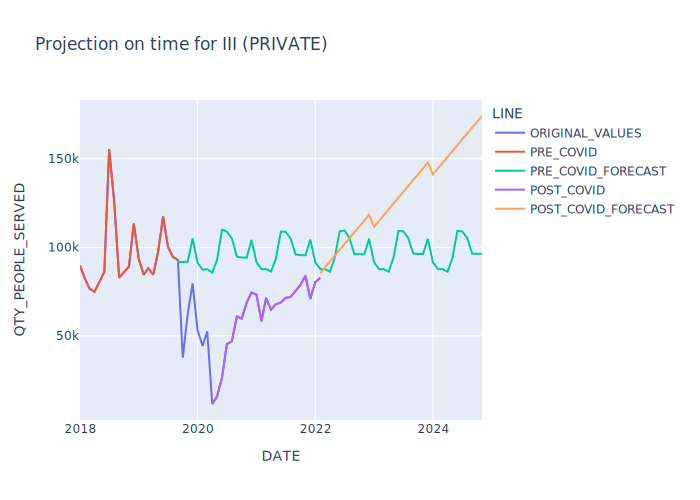

In [17]:
forecast_df = forecast_df.melt(id_vars=['DATE'],
                               var_name="LINE",
                               value_name="QTY_PEOPLE_SERVED")


fig = px.line(forecast_df,
              x="DATE",
              y="QTY_PEOPLE_SERVED",
              color='LINE',
              title='Projection on time for ' + TAG_CATEGORY +' ('+TAG_SECTOR+')')

#fig.show()
fig.show(renderer="svg")

In [18]:
all_data = pd.read_pickle('data/morbilidad_global_lima.pkl')
all_data.head()

,DATE,YEAR,MONTH,STATE,PROVINCE,DISTRICT,SECTOR,CATEGORY,CATEGORY2,CO_IPRESS,...,DIAGNOSIS_ID,QTY_PEOPLE_SERVED,DISEASE,DISEASE_GROUP,COD_IPRESS,x,y,SECTOR_R,TYPE,SECTOR2
0,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,II,00015610,...,R10.2,10,PELVIC AND PERINEAL PAIN,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,PRIVATE
1,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,II,00015610,...,R10.4,11,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,PRIVATE
2,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,II,00015610,...,R11.X,3,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,PRIVATE
3,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,II,00015610,...,R16.0,1,"HEPATOMEGALY, NOT ELSEWHERE CLASSIFIED","Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,PRIVATE
4,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVADO,II-2,II,00015610,...,R42.X,1,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,PRIVATE


In [19]:
#train, test = model_selection.train_test_split(data_sector_ts_pre['QTY_PEOPLE_SERVED'].values, train_size=0.9)
model = pm.auto_arima(data_sector_ts_pre, seasonal=True, m=3)

NameError: name 'pm' is not defined

In [ ]:
#preds = model.predict(test.shape[0])

In [ ]:

cv = model_selection.SlidingWindowForecastCV(window_size=None, step=1, h=1)

model_cv_scores = model_selection.cross_val_score(model, data_sector_ts_pre, scoring='smape', cv=cv, verbose=1)

model_cv_scores.tolist()
average_error = np.average(model_cv_scores)
average_error

In [ ]:
data_sector_ts_post.index

In [ ]:
model.predict(data_sector_ts_post.index)

In [ ]:
#x = np.arange(y.shape[0])
plt.plot(data_sector_ts_pre['QTY_PEOPLE_SERVED'].values, train)
plt.plot(test['QTY_PEOPLE_SERVED'].values, preds)
plt.show()

In [ ]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

import statsmodels.datasets.co2 as co2
co2_data = co2.load().data
co2_data = co2_data.fillna(co2_data.interpolate())

In [ ]:
train, test = train_test_split(co2_data.co2.values, train_size=0.9)

In [ ]:
len(co2_data), len(train), len(test)

In [ ]:
model = pm.auto_arima(train, seasonal=True, m=52)
preds = model.predict(test.shape[0])

In [ ]:
x = np.arange(y.shape[0])
plt.plot(co2_data.co2.values[:2200], train)
plt.plot(co2_data.co2.values[2200:], preds)
plt.show()

In [ ]:
# # Precovid
# df_reindexed = data_sector_ts_pre.reindex(pd.date_range(start=data_sector_ts_pre.index.min(),
#                                                         end=data_sector_ts_pre.index.max(),
#                                                         freq='1D')) 
# df_reindexed.index.name = 'DATE'
# df_reindexed = df_reindexed[(df_reindexed.index.strftime('%d') == '01') | (df_reindexed.index.strftime('%d') == '15')]
# df_reindexed = df_reindexed.interpolate(method='linear') 

# df_reindexed